<a href="https://colab.research.google.com/github/defneuras/Cloud-detection-in-the-Arctic/blob/main/DataRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install earthengine-api

In [ ]:
!earthengine authenticate

E0000 00:00:1753791370.831696    1433 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753791370.844022    1433 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W0729 12:16:16.248889 133903011958784 _default.py:711] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20h

In [ ]:
import ee
ee.Initialize(project='ee-urasdefne')

In [ ]:
aoi = ee.Geometry.Rectangle([-79.5, 72.0, -77.5, 73.0])

# Quality computation
def add_quality_metrics(image):
    scl = image.select('SCL')
    snow = scl.eq(11)
    cloud = scl.eq(8).Or(scl.eq(9)).Or(scl.eq(10))
    snow_cloud = snow.Or(cloud)
    no_data = scl.eq(0)

    snow_cloud_fraction = snow_cloud.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=20,
        maxPixels=1e9
    ).get('SCL')

    no_data_fraction = no_data.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=20,
        maxPixels=1e9
    ).get('SCL')

    return image.set({
        'snow_cloud_fraction': snow_cloud_fraction,
        'no_data_fraction': no_data_fraction
    })

# Sentinel-2 filtering
s2 = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(aoi)
    .filterDate('2025-03-01', '2025-06-23')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60))
    .map(add_quality_metrics)
    .filter(ee.Filter.notNull(['snow_cloud_fraction', 'no_data_fraction']))
    .filter(ee.Filter.gte('snow_cloud_fraction', 0.2))
    .filter(ee.Filter.lte('no_data_fraction', 0))
)

# Convert each image to a metadata feature
def image_to_feature(img):
    return ee.Feature(None, {
        'date': img.date().format('YYYY-MM-dd'),
        'cloud_pct': img.get('CLOUDY_PIXEL_PERCENTAGE'),
        'snow_cloud_frac': img.get('snow_cloud_fraction'),
        'tile': img.get('system:index'),
        'satellite': img.get('SPACECRAFT_NAME')
    })

metadata_fc = s2.map(image_to_feature)

# Export the metadata to Google Drive
task = ee.batch.Export.table.toDrive(
    collection=metadata_fc,
    description='pond_inlet_metadata_smallAOI',
    folder='Sentinel2_PondInlet_Exports',
    fileNamePrefix='arctic_filtered_metadata',
    fileFormat='CSV'
)
task.start()

print("✅ Metadata export started — check Earth Engine Tasks tab.")

✅ Metadata export started — check Earth Engine Tasks tab.


In [ ]:
# Copernicus credentials
username = "username"
password = "password"

# Step 1: Authenticate and get token
def get_access_token(username, password):
    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {
        "grant_type": "password",
        "username": username,
        "password": password,
        "client_id": "cdse-public",
    }
    r = requests.post(url, data=data)
    r.raise_for_status()
    return r.json()["access_token"]

# Step 2: Search for Sentinel-2 products by tile and date
def search_products_by_tile_and_date(tile, date, token):
    base_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products"
    start = f"{date}T00:00:00.000Z"
    end = f"{date}T23:59:59.999Z"
    filter_query = (
        f"$filter=contains(Name,'{tile}') and ContentDate/Start ge {start} and ContentDate/Start le {end} "
        f"and Collection/Name eq 'SENTINEL-2'"
    )
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(f"{base_url}?{filter_query}", headers=headers)
    response.raise_for_status()
    return response.json().get("value", [])

# Step 3: Run the query
token = get_access_token(username, password)
results = search_products_by_tile_and_date(tile_id, target_date, token)

# Step 4: Show the matching product names
if results:
    for i, product in enumerate(results):
        print(f"{i}: {product['Name']} — ID: {product['Id']}")
else:
    print("No products found for that tile and date.")

0: S2C_MSIL1C_20250301T175311_N0511_R141_T17WNV_20250301T193907.SAFE — ID: 281753f8-d9f8-41a4-8da9-175a2cc0b4d5
1: S2C_MSIL2A_20250301T175311_N0511_R141_T17WNV_20250301T210709.SAFE — ID: f9d81023-196d-4de9-8301-326c75acc734


In [ ]:
import os
import requests

# Your access token (already retrieved earlier in your session)
access_token = token

# === Your matching product info ===
product_id = "f9d81023-196d-4de9-8301-326c75acc734"
file_name = "S2C_MSIL2A_20250301T175311_N0511_R141_T17WNV_20250301T210709"

# ✅ Correct Google Drive folder
download_dir = "/content/drive/MyDrive/Sentinel2_PondInlet_Exports/S2_Downloads"

# === Download function ===
def download_single_product(product_id, file_name, access_token, download_dir="/content"):
    os.makedirs(download_dir, exist_ok=True)
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
    headers = {"Authorization": f"Bearer {access_token}"}
    r = requests.get(url, headers=headers, stream=True)

    if r.status_code == 200:
        file_path = os.path.join(download_dir, file_name + ".zip")
        with open(file_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"✅ Downloaded to: {file_path}")
    else:
        print(f"❌ Download failed — {r.status_code}: {r.text}")

# === Start download ===
download_single_product(product_id, file_name, access_token, download_dir)

✅ Downloaded to: /content/drive/MyDrive/Sentinel2_PondInlet_Exports/S2_Downloads/S2C_MSIL2A_20250301T175311_N0511_R141_T17WNV_20250301T210709.zip


In [ ]:
# Load and preprocess Sentinel-2 data
!pip install rasterio

In [ ]:
import os
from glob import glob
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import zipfile

In [ ]:
zip_path = "/content/drive/MyDrive/Sentinel2_PondInlet_Exports/S2_Downloads/S2C_MSIL2A_20250301T175311_N0511_R141_T17WNV_20250301T210709.zip"

extract_dir = "/content/drive/MyDrive/Sentinel2_PondInlet_Exports/S2_Downloads"

# Unzip if not already unzipped
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")

Extraction complete.


In [ ]:
# Path to the .SAFE directory
safe_dir = "/content/drive/MyDrive/Sentinel2_PondInlet_Exports/S2_Downloads/S2C_MSIL2A_20250301T175311_N0511_R141_T17WNV_20250301T210709.SAFE"

# Locate GRANULE folder
granule_dir = glob(os.path.join(safe_dir, "GRANULE", "*"))[0]

# Locate image folders
img_data_10m = os.path.join(granule_dir, "IMG_DATA", "R10m")
img_data_20m = os.path.join(granule_dir, "IMG_DATA", "R20m")

# Define bands of interest
bands_10m = ["B02", "B03", "B04", "B08"]
bands_20m = ["B11", "B12"]
band_paths = {}

# Collect 10m bands
for b in bands_10m:
    pattern = os.path.join(img_data_10m, f"*_{b}_10m.jp2")
    band_paths[b] = glob(pattern)[0]

# Collect 20m bands
for b in bands_20m:
    pattern = os.path.join(img_data_20m, f"*_{b}_20m.jp2")
    band_paths[b] = glob(pattern)[0]

# SCL path
scl_path = glob(os.path.join(img_data_20m, "*_SCL_20m.jp2"))[0]

In [ ]:
# Function to manually upscale 20m bands to 10m using nearest-neighbor
def upscale_20m_to_10m(band_20m):
    return np.repeat(np.repeat(band_20m, 2, axis=0), 2, axis=1)

# Bands at 10m resolution
bands_10m = ["B02", "B03", "B04", "B08"]
# Bands at 20m that need upscaling
bands_20m = ["B11", "B12"]

all_bands = {}

# Load 10m bands
for b in bands_10m:
    with rasterio.open(band_paths[b]) as src:
        all_bands[b] = src.read(1)

# Load and upscale 20m bands
for b in bands_20m:
    with rasterio.open(band_paths[b]) as src:
        band = src.read(1)
        all_bands[b] = upscale_20m_to_10m(band)

# Load and upscale SCL
with rasterio.open(scl_path) as src:
    scl = src.read(1)
    scl_10m = upscale_20m_to_10m(scl)

print("Loaded and upscaled all bands to 10m resolution.")
print("Band shapes:")
for b, arr in all_bands.items():
    print(f"{b}: {arr.shape}")
print(f"SCL: {scl_10m.shape}")

# Optional: Stack all features into (H, W, C)
feature_stack = np.stack([all_bands[b] for b in bands_10m + bands_20m], axis=-1)
print(f"\nFeature stack shape: {feature_stack.shape} (Height, Width, Bands)")

Loaded and upscaled all bands to 10m resolution.
Band shapes:
B02: (10980, 10980)
B03: (10980, 10980)
B04: (10980, 10980)
B08: (10980, 10980)
B11: (10980, 10980)
B12: (10980, 10980)
SCL: (10980, 10980)

Feature stack shape: (10980, 10980, 6) (Height, Width, Bands)


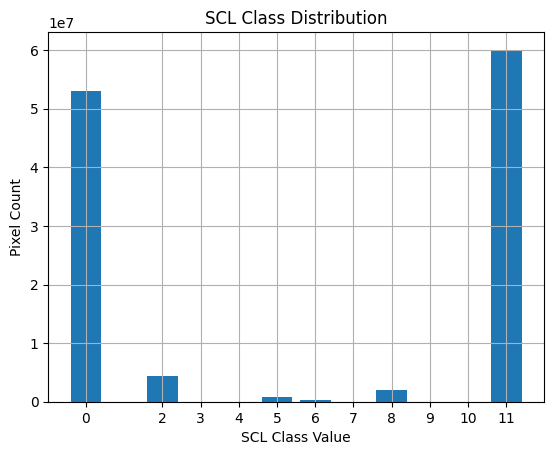

In [ ]:
unique, counts = np.unique(scl_10m, return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique)
plt.xlabel("SCL Class Value")
plt.ylabel("Pixel Count")
plt.title("SCL Class Distribution")
plt.grid(True)
plt.show()

In [ ]:
# Flatten feature stack and SCL
H, W, C = feature_stack.shape
X = feature_stack.reshape(-1, C)
scl_flat = scl_10m.flatten()

# Mask: keep only valid pixels (SCL ≠ 0)
valid_mask = scl_flat != 0
X_valid = X[valid_mask]
scl_valid = scl_flat[valid_mask]

print(f"X_valid shape: {X_valid.shape}")
print(f"SCL valid unique values: {np.unique(scl_valid)}")

X_valid shape: (67594812, 6)
SCL valid unique values: [ 2  3  4  5  6  7  8  9 10 11]


In [ ]:
# Dimensions
H, W = scl_10m.shape
split_row = H // 2  # Horizontal split

# Split SCL
scl_top = scl_10m[:split_row, :]
scl_bottom = scl_10m[split_row:, :]

# Mask out no-data (SCL == 0)
scl_masked_top = np.where(scl_top == 0, np.nan, scl_top)
scl_masked_bottom = np.where(scl_bottom == 0, np.nan, scl_bottom)

In [ ]:
def create_patches(X, y, patch_size=64, classes=[2,3,4,5,6,7,8,9,10,11]):
    H, W, C = X.shape
    patches = []
    labels = []
    for i in range(0, H - patch_size, patch_size):
        for j in range(0, W - patch_size, patch_size):
            patch = X[i:i+patch_size, j:j+patch_size, :]
            label_patch = y[i:i+patch_size, j:j+patch_size]
            unique = np.unique(label_patch)
            unique = unique[unique != 0]
            if len(unique) == 1 and unique[0] in classes:
                patches.append(patch)
                labels.append(unique[0])
    return np.array(patches), np.array(labels)

patches, patch_labels = create_patches(feature_stack, scl_10m)
print("✅ Patches:", patches.shape, "Labels:", patch_labels.shape)

✅ Patches: (10402, 64, 64, 6) Labels: (10402,)


In [ ]:
# Save patches and labels to disk
np.save("/content/drive/MyDrive/Sentinel2_PondInlet_Exports/X_patches.npy", patches)
np.save("/content/drive/MyDrive/Sentinel2_PondInlet_Exports/y_labels.npy", patch_labels)

print("✅ Saved patch data to Google Drive.")

✅ Saved patch data to Google Drive.


In [ ]:
print("X_patches shape:", patches.shape)      # Should be (N, 64, 64, 6)
print("y_labels shape:", patch_labels.shape)  # Should be (N,)

# Check pixel value range (should not be all 0 or nan)
print("Patch min:", np.min(patches))
print("Patch max:", np.max(patches))
print("Unique labels:", np.unique(patch_labels))

X_patches shape: (10402, 64, 64, 6)
y_labels shape: (10402,)
Patch min: 0
Patch max: 16192
Unique labels: [ 2  5  6  8 11]
